<a href="https://colab.research.google.com/github/ngonzalezromo/skullbase-res/blob/main/Zeiss_Trenion_Camera_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Skullbaseresearch.com 

ngr@skullbaseresearch.com

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import dependencies
import numpy as np
from numpy import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
#Find chessboard corners
left_mask = "/content/drive/MyDrive/stereoLeft/*.JPG"
right_mask= "/content/drive/MyDrive/stereoRight/*.JPG"
chessboardSize = (9,6)
figsize = (10, 10)
square_size=5

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)
objp = objp * square_size

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

In [ ]:
#Define path of pictures 
imagesLeft = glob(left_mask)
imagesRight = glob(right_mask)

In [ ]:
for imgLeft, imgRight in zip(imagesLeft, imagesRight):

    imgL = cv2.imread(imgLeft)
    imgR = cv2.imread(imgRight)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(grayL, chessboardSize, None)
    retR, cornersR = cv2.findChessboardCorners(grayR, chessboardSize, None)

    # If found, add object points, image points (after refining them)
    if retL and retR == True:

        objpoints.append(objp)

        cornersL = cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)

        cornersR = cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        img_l_corners= cv2.drawChessboardCorners(imgL, chessboardSize, cornersL, retL)
        img_r_corners= cv2.drawChessboardCorners(imgR, chessboardSize, cornersR, retR)
        #cv2_imshow(img_l_corners)
        #cv2_imshow(img_r_corners)



In [ ]:
############## CALIBRATION #######################################################
#alpha set to zero, no black pixels are 
frameSize= (960,1080)
retL, cameraMatrixL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, frameSize, None,4, None,None,cv2.CALIB_ZERO_TANGENT_DIST)
newCameraMatrixL, roi_L = cv2.getOptimalNewCameraMatrix(cameraMatrixL, distL, (960,1080), 0, (960,1080))

retR, cameraMatrixR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, frameSize, None,4, None, None,cv2.CALIB_ZERO_TANGENT_DIST)
newCameraMatrixR, roi_R = cv2.getOptimalNewCameraMatrix(cameraMatrixR, distR, (960,1080), 0, (960,1080))

In [ ]:
########## Stereo Vision Calibration #############################################

#flags = 0
#flags = cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, rot, trans, essentialMatrix, fundamentalMatrix = cv2.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL, distL, newCameraMatrixR, distR, (960,1080), criteria_stereo, flags = cv2.CALIB_FIX_INTRINSIC)

print("Optimal camera matrix Left camera\n", newCameraMatrixL)

print("Optimal camera matrix Right camera\n", newCameraMatrixR)

print("Essential matrix\n", essentialMatrix)

print("Fundamental matrix\n", fundamentalMatrix)


Optimal camera matrix Left camera
 [[4.07696387e+03 0.00000000e+00 3.68414628e+02]
 [0.00000000e+00 8.27615234e+03 6.59844896e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Optimal camera matrix Right camera
 [[4.09485962e+03 0.00000000e+00 4.06613843e+02]
 [0.00000000e+00 8.35058398e+03 6.28731350e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Essential matrix
 [[ -0.10942634  -4.26587698   3.50305573]
 [  3.78238953   0.10496687  15.10781525]
 [ -3.44895107 -14.97893399  -0.01945652]]
Fundamental matrix
 [[ 9.00412719e-07  1.72916515e-05 -1.29259338e-01]
 [-1.52618852e-05 -2.08642401e-07 -2.42770564e-01]
 [ 1.25440124e-01  2.41727030e-01  1.00000000e+00]]


In [ ]:
########## Stereo Rectification #################################################
rectL, rectR, projMatrixL, projMatrixR, Q, roi_L, roi_R= cv2.stereoRectify(newCameraMatrixL, distL, newCameraMatrixR, distR, (960,1080), rot, trans,flags=cv2.CALIB_ZERO_DISPARITY)

stereoMapL = cv2.initUndistortRectifyMap(newCameraMatrixL, distL, rectL, projMatrixL,(960,1080), cv2.CV_32FC1)
stereoMapR = cv2.initUndistortRectifyMap(newCameraMatrixR, distR, rectR, projMatrixR, (960,1080), cv2.CV_32FC1)

In [ ]:
# Reprojection Error
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecsL[i], tvecsL[i], newCameraMatrixL, distL)
    error = cv2.norm(imgpointsL[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("total error: {}".format(mean_error/len(objpoints)))

total error: 0.33864423353847395


$reprojection\,error=0.33864423353847395$

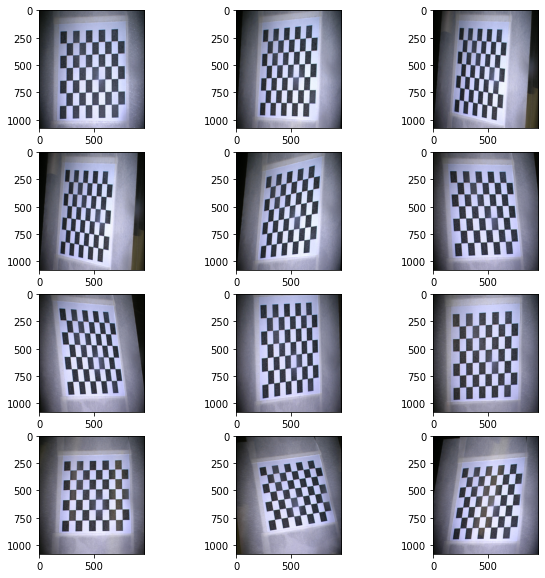

Done


In [ ]:
# Undistort
plt.figure(figsize=figsize)
for i, fn in enumerate(imagesLeft):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, cameraMatrixL, distL)
    if i < 12:
        plt.subplot(4, 3, i + 1)
        plt.imshow(dst)

plt.show()
print("Done")

In [ ]:
#Save parameters 
import pickle

In [ ]:
calib_result_pickle_L = {}
calib_result_pickle_L["mtx"] = cameraMatrixL
calib_result_pickle_L["optimal_camera_matrix"] = newCameraMatrixL
calib_result_pickle_L["dist"] = distL
calib_result_pickle_L["rvecs"] = rvecsL
calib_result_pickle_L["tvecs"] = tvecsL
pickle.dump(calib_result_pickle_L, open("camera_calib_pickle_L.p", "wb" )) 

In [ ]:
calib_result_pickle_R = {}
calib_result_pickle_R["mtx"] = cameraMatrixR
calib_result_pickle_R["optimal_camera_matrix"] = newCameraMatrixR
calib_result_pickle_R["dist"] = distR
calib_result_pickle_R["rvecs"] = rvecsR
calib_result_pickle_R["tvecs"] = tvecsR
pickle.dump(calib_result_pickle_R, open("camera_calib_pickle_R.p", "wb" )) 

In [ ]:
calib_result_pickle = {}
calib_result_pickle["emtx"] = essentialMatrix
calib_result_pickle["fmtx"] = fundamentalMatrix
calib_result_pickle["Q"] = Q
pickle.dump(calib_result_pickle, open("camera_calib_pickle.p", "wb" )) 

In [ ]:
print (Q)
print (Q.dtype)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.46626231e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -8.50934515e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.31336816e+03]
 [ 0.00000000e+00  0.00000000e+00  6.26649112e-02 -0.00000000e+00]]
float64


In [ ]:
!pip install array_to_latex


In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(cameraMatrixL)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  4098.71 &    0.00 &  365.77\\
    0.00 &  8296.81 &  660.92\\
    0.00 &    0.00 &    1.00
\end{pmatrix}


$Left\,camera\,matrix=$
$ \begin{pmatrix}
  4098.71 &    0.00 &  365.77\\
    0.00 &  8296.81 &  660.92\\
    0.00 &    0.00 &    1.00
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(newCameraMatrixL)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  4076.96 &    0.00 &  368.41\\
    0.00 &  8276.15 &  659.84\\
    0.00 &    0.00 &    1.00
\end{pmatrix}


$Optimal\,left\,camera\,matrix=$
$\begin{pmatrix}
  4076.96 &    0.00 &  368.41\\
    0.00 &  8276.15 &  659.84\\
    0.00 &    0.00 &    1.00
\end{pmatrix} $

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(cameraMatrixR)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  4074.78 &    0.00 &  402.10\\
    0.00 &  8267.91 &  630.68\\
    0.00 &    0.00 &    1.00
\end{pmatrix}


$Right\,camera\,matrix=$
$ \begin{pmatrix}
  4074.78 &    0.00 &  402.10\\
    0.00 &  8267.91 &  630.68\\
    0.00 &    0.00 &    1.00
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(newCameraMatrixR)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  4094.86 &    0.00 &  406.61\\
    0.00 &  8350.58 &  628.73\\
    0.00 &    0.00 &    1.00
\end{pmatrix}


$Optimal\,right\,camera\,matrix=$
$ \begin{pmatrix}
  4094.86 &    0.00 &  406.61\\
    0.00 &  8350.58 &  628.73\\
    0.00 &    0.00 &    1.00
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(essentialMatrix)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  -0.11 &  -4.27 &    3.50\\
    3.78 &    0.10 &   15.11\\
  -3.45 & -14.98 &  -0.02
\end{pmatrix}


$Essential\,camera\,matrix=$
$\begin{pmatrix}
  -0.11 &  -4.27 &    3.50\\
    3.78 &    0.10 &   15.11\\
  -3.45 & -14.98 &  -0.02
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(fundamentalMatrix)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
    0.00 &    0.00 &  -0.13\\
  -0.00 &  -0.00 &  -0.24\\
    0.13 &    0.24 &    1.00
\end{pmatrix}


$Fundamental\,camera\,matrix=$
$\begin{pmatrix}
    0.00 &    0.00 &  -0.13\\
  -0.00 &  -0.00 &  -0.24\\
    0.13 &    0.24 &    1.00
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(Q)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
    1.00 &    0.00 &    0.00 & -2466.26\\
    0.00 &    1.00 &    0.00 & -850.93\\
    0.00 &    0.00 &    0.00 &  8313.37\\
    0.00 &    0.00 &    0.06 &   -0.00
\end{pmatrix}


$Q=$
$\begin{pmatrix}
    1.00 &    0.00 &    0.00 & -2466.26\\
    0.00 &    1.00 &    0.00 & -850.93\\
    0.00 &    0.00 &    0.00 &  8313.37\\
    0.00 &    0.00 &    0.06 &   -0.00
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(distL)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  -2.16\\
   77.46\\
    0.00\\
    0.00\\
    0.68
\end{pmatrix}


$Distortion\,coefficients\,left\,camera=$
$\begin{pmatrix}
  -2.16 \qquad
   77.46 \qquad
    0.00 \qquad
    0.00 \qquad
    0.68 \,
\end{pmatrix}$

In [ ]:
#Create latex matrix 
import array_to_latex as a2l
A = np.array(distR)
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'pmatrix')

\begin{pmatrix}
  -2.21\\
  115.36\\
    0.00\\
    0.00\\
    1.17
\end{pmatrix}


$Distortion\,coefficients\,right\,camera=$
$\begin{pmatrix}
-2.21\qquad
115.36\quad
0.00\quad
0.00\quad
1.17\,
\end{pmatrix}$

In [ ]:
print(tvecsL)

[array([[-0.00942322],
       [-0.01489418],
       [ 0.35036091]]), array([[-0.00639311],
       [-0.01620094],
       [ 0.3633544 ]]), array([[-0.0079498 ],
       [-0.01716642],
       [ 0.37118834]]), array([[-0.00797206],
       [-0.01719937],
       [ 0.37114672]]), array([[-0.00408458],
       [-0.01472275],
       [ 0.36285083]]), array([[-0.01181178],
       [-0.01544034],
       [ 0.33936682]]), array([[-0.00938894],
       [-0.0170135 ],
       [ 0.33946168]]), array([[-0.00684451],
       [-0.01793166],
       [ 0.33905775]]), array([[-0.0101716 ],
       [-0.01474216],
       [ 0.33912971]]), array([[-0.00657766],
       [-0.01441422],
       [ 0.34958278]]), array([[-0.00680636],
       [-0.01265231],
       [ 0.34741814]]), array([[-0.00430553],
       [-0.01195434],
       [ 0.35490793]]), array([[-0.00488442],
       [-0.0167678 ],
       [ 0.36759909]]), array([[-0.01552513],
       [-0.01802968],
       [ 0.37289701]]), array([[-0.0024383 ],
       [-0.01902479],
   

In [ ]:
print (tvecsR)

[array([[-0.01250774],
       [-0.01379288],
       [ 0.35288299]]), array([[-0.00907444],
       [-0.01516913],
       [ 0.36521935]]), array([[-0.01037475],
       [-0.01619889],
       [ 0.37314547]]), array([[-0.01039363],
       [-0.01623078],
       [ 0.37306487]]), array([[-0.00673653],
       [-0.0137097 ],
       [ 0.36480296]]), array([[-0.01539212],
       [-0.01423637],
       [ 0.34177464]]), array([[-0.01299453],
       [-0.0158034 ],
       [ 0.34168816]]), array([[-0.01046617],
       [-0.01670618],
       [ 0.34079284]]), array([[-0.0136093 ],
       [-0.01359709],
       [ 0.34189224]]), array([[-0.00967088],
       [-0.01329617],
       [ 0.35211686]]), array([[-0.00999309],
       [-0.01151595],
       [ 0.35007848]]), array([[-0.00718223],
       [-0.01086822],
       [ 0.35726334]]), array([[-0.00746045],
       [-0.0157927 ],
       [ 0.36934351]]), array([[-0.01793271],
       [-0.01708321],
       [ 0.37501287]]), array([[-0.00603887],
       [-0.0177742 ],
   

In [ ]:
print (rvecsL)

[array([[-0.26465996],
       [ 0.09732689],
       [-0.00314458]]), array([[-0.16210562],
       [ 0.56211372],
       [ 0.03753931]]), array([[-0.10644517],
       [ 0.71786016],
       [ 0.09820054]]), array([[-0.10624503],
       [ 0.71785573],
       [ 0.09808398]]), array([[-0.36919287],
       [ 0.59361179],
       [ 0.03909755]]), array([[-0.43592847],
       [-0.28593636],
       [-0.07482705]]), array([[-0.39962781],
       [-0.53602233],
       [-0.11071328]]), array([[ 0.01970587],
       [-0.46857247],
       [-0.05056294]]), array([[ 0.37456661],
       [-0.06787061],
       [-0.01586159]]), array([[-0.69323727],
       [ 0.05800621],
       [ 0.01290133]]), array([[-0.79966971],
       [-0.22700082],
       [-0.18141232]]), array([[-0.65438325],
       [ 0.37141813],
       [ 0.10555004]]), array([[-0.15444141],
       [ 0.8002651 ],
       [ 0.05457005]]), array([[0.20097102],
       [0.7548794 ],
       [0.03213226]]), array([[ 0.0618036 ],
       [-0.31547876],
      

In [ ]:
print (rvecsL)

[array([[-0.26465996],
       [ 0.09732689],
       [-0.00314458]]), array([[-0.16210562],
       [ 0.56211372],
       [ 0.03753931]]), array([[-0.10644517],
       [ 0.71786016],
       [ 0.09820054]]), array([[-0.10624503],
       [ 0.71785573],
       [ 0.09808398]]), array([[-0.36919287],
       [ 0.59361179],
       [ 0.03909755]]), array([[-0.43592847],
       [-0.28593636],
       [-0.07482705]]), array([[-0.39962781],
       [-0.53602233],
       [-0.11071328]]), array([[ 0.01970587],
       [-0.46857247],
       [-0.05056294]]), array([[ 0.37456661],
       [-0.06787061],
       [-0.01586159]]), array([[-0.69323727],
       [ 0.05800621],
       [ 0.01290133]]), array([[-0.79966971],
       [-0.22700082],
       [-0.18141232]]), array([[-0.65438325],
       [ 0.37141813],
       [ 0.10555004]]), array([[-0.15444141],
       [ 0.8002651 ],
       [ 0.05457005]]), array([[0.20097102],
       [0.7548794 ],
       [0.03213226]]), array([[ 0.0618036 ],
       [-0.31547876],
      